<a href="https://colab.research.google.com/github/glorious0119/Project-Oxford_IIIT_Pet_TorchVision/blob/master/Part_6_Replicating_Vision_Transformer_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Transformer architecture is generally considered to be any neural network that uses the attention mechanism) as its primary learning layer. Similar to how a convolutional neural network (CNN) uses convolutions as its primary learning layer.

There are 37 categories of pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

!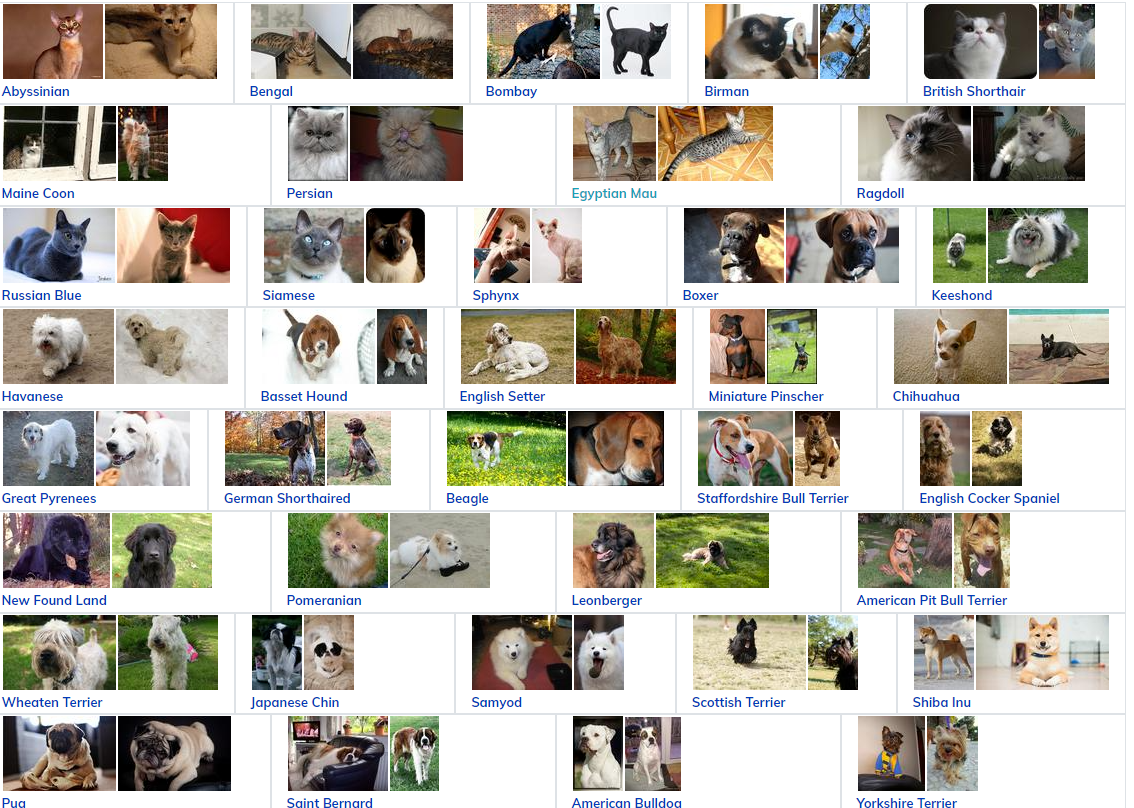

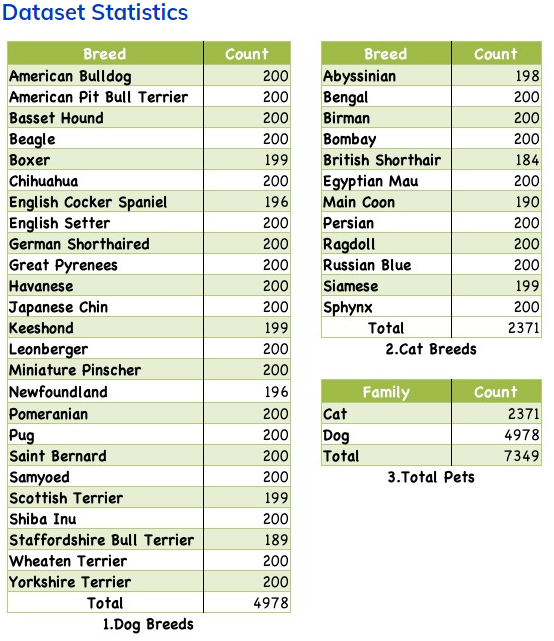

# 1. Get data

In [1]:
import requests
import zipfile
from pathlib import Path

# Function to download a zip file from a URL
def download_zip(url, save_path):
    """Downloads zip files from the given URL and saves it to the specified path."""
    if not save_path.is_file():  # Only download if the file doesn't already exist
        try:
            print(f"Downloading data from {url}...")
            response = requests.get(url)
            response.raise_for_status()  # Raise an error for bad responses
            with open(save_path, "wb") as f:
                f.write(response.content)
            print(f"Downloaded and saved at {save_path}.")
        except requests.exceptions.RequestException as e:
            print(f"[ERROR] Failed to download {url}: {e}")
    else:
        print(f"{save_path} already exists. Skipping download.")

# Function to unzip a file to a specified directory
def unzip_file(zip_path, extract_to):
    """Unzips a zip file to the specified directory."""
    if zip_path.is_file():  # Check if the zip file exists
        print(f"Unzipping {zip_path} to {extract_to}...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Unzipped to {extract_to}.")
    else:
        print(f"[ERROR] {zip_path} does not exist. Cannot unzip.")

# Define datasets with URLs and paths
datasets = {
    "50_percent": {
        "train_url": "https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision/raw/refs/heads/master/experimentation_data/train_data_50_percent_3_classes.zip",
        "test_url": "https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision/raw/refs/heads/master/experimentation_data/test_data_50_percent_3_classes.zip",
        "train_path": Path("data/train_data_50"),
        "test_path": Path("data/test_data_50"),
        "train_zip": Path("data/train_data_50.zip"),
        "test_zip": Path("data/test_data_50.zip")
    },
    "100_percent": {
        "train_url": "https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision/raw/refs/heads/master/experimentation_data/train_data_100_percent_3_classes.zip",
        "train_path": Path("data/train_data_100"),
        "train_zip": Path("data/train_data_100.zip")
    }
}

# Create directories and process each dataset
for key, dataset in datasets.items():
    # Create directories if they don't exist
    dataset["train_path"].mkdir(parents=True, exist_ok=True)
    if "test_path" in dataset:
        dataset["test_path"].mkdir(parents=True, exist_ok=True)

    # Download train data
    download_zip(dataset["train_url"], dataset["train_zip"])

    # Unzip the downloaded train file
    unzip_file(dataset["train_zip"], dataset["train_path"])

    # If the test URL is provided, download and unzip test data
    if "test_url" in dataset:
        download_zip(dataset["test_url"], dataset["test_zip"])
        unzip_file(dataset["test_zip"], dataset["test_path"])

    # Delete the zip files if they exist
    if dataset["train_zip"].is_file():
        dataset["train_zip"].unlink()
    if "test_zip" in dataset and dataset["test_zip"].is_file():
        dataset["test_zip"].unlink()

# Set up directories for training and testing
train_50_image_path = Path("data/train_data_50")
test_50_image_path = Path("data/test_data_50")
train_100_image_path = Path("data/train_data_100")

Downloaded and saved at data/train_data_50.zip.
Unzipping data/train_data_50.zip to data/train_data_50...
Unzipped to data/train_data_50.
Downloaded and saved at data/test_data_50.zip.
Unzipping data/test_data_50.zip to data/test_data_50...
Unzipped to data/test_data_50.
Downloaded and saved at data/train_data_100.zip.
Unzipping data/train_data_100.zip to data/train_data_100...
Unzipped to data/train_data_100.


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
import sys

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] Installing torchinfo....")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the Part_3_pet_modules directory
!git clone https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision.git
!mv Project-Oxford_IIIT_Pet_TorchVision/Part_3_pet_modules .
!rm -rf Project-Oxford_IIIT_Pet_TorchVision

[INFO] Installing torchinfo....
Cloning into 'Project-Oxford_IIIT_Pet_TorchVision'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 53 (delta 5), reused 9 (delta 3), pack-reused 40 (from 1)
Receiving objects: 100% (53/53), 64.75 MiB | 46.11 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [3]:
# Set up device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Set up directories
train_dir_50 = train_50_image_path / "data" / "images"
test_dir_50 = test_50_image_path / "data" / "images"
train_dir_100 = train_100_image_path / "data" / "images"

print(f"Training Directory (50%) for 3 classes: {train_dir_50}")
print(f"Testing Directory (50%) for 3 classes: {test_dir_50}")
print(f"Training Directory (100%) for 3 classes: {train_dir_100}")

Training Directory (50%) for 3 classes: data/train_data_50/data/images
Testing Directory (50%) for 3 classes: data/test_data_50/data/images
Training Directory (100%) for 3 classes: data/train_data_100/data/images


# 2. Create DataLoaders and transform Datasets

## 2.1 Create manual transform for images

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 2.2 Turn images into DataLoaders

Because some hardware (including the free tier of Google Colab) may not be able to handle a batch size of 4096 as stated in the ViT paper. However, we're going to use a batch size of 32.

In [6]:
from Part_3_pet_modules import data_setup

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_50,
    test_dir=test_dir_50,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d8f2a9399c0>,
 ['boxer', 'pug', 'sphynx'])

## 2.3 Visualize a random image from the dataset

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

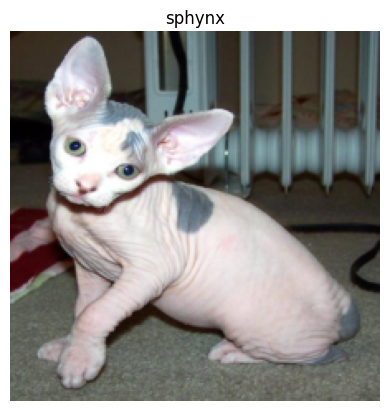

In [8]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# 3. Replicating ViT paper

https://arxiv.org/abs/2010.11929

## 3.1 Calculating patch embedding input and output shapes by hand

In [9]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [10]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


## 3.2 Turning a single image into patches

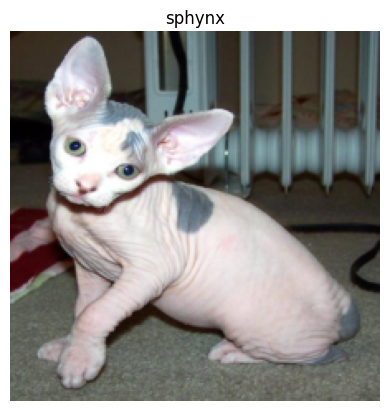

In [11]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

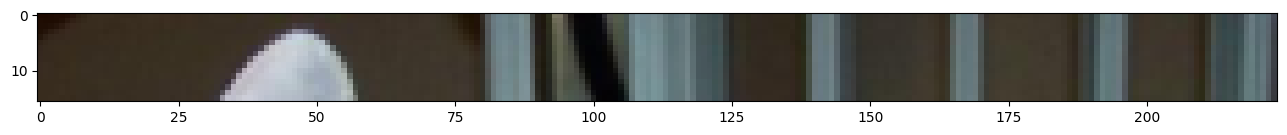

In [12]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


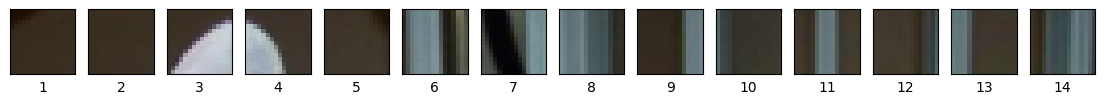

In [13]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


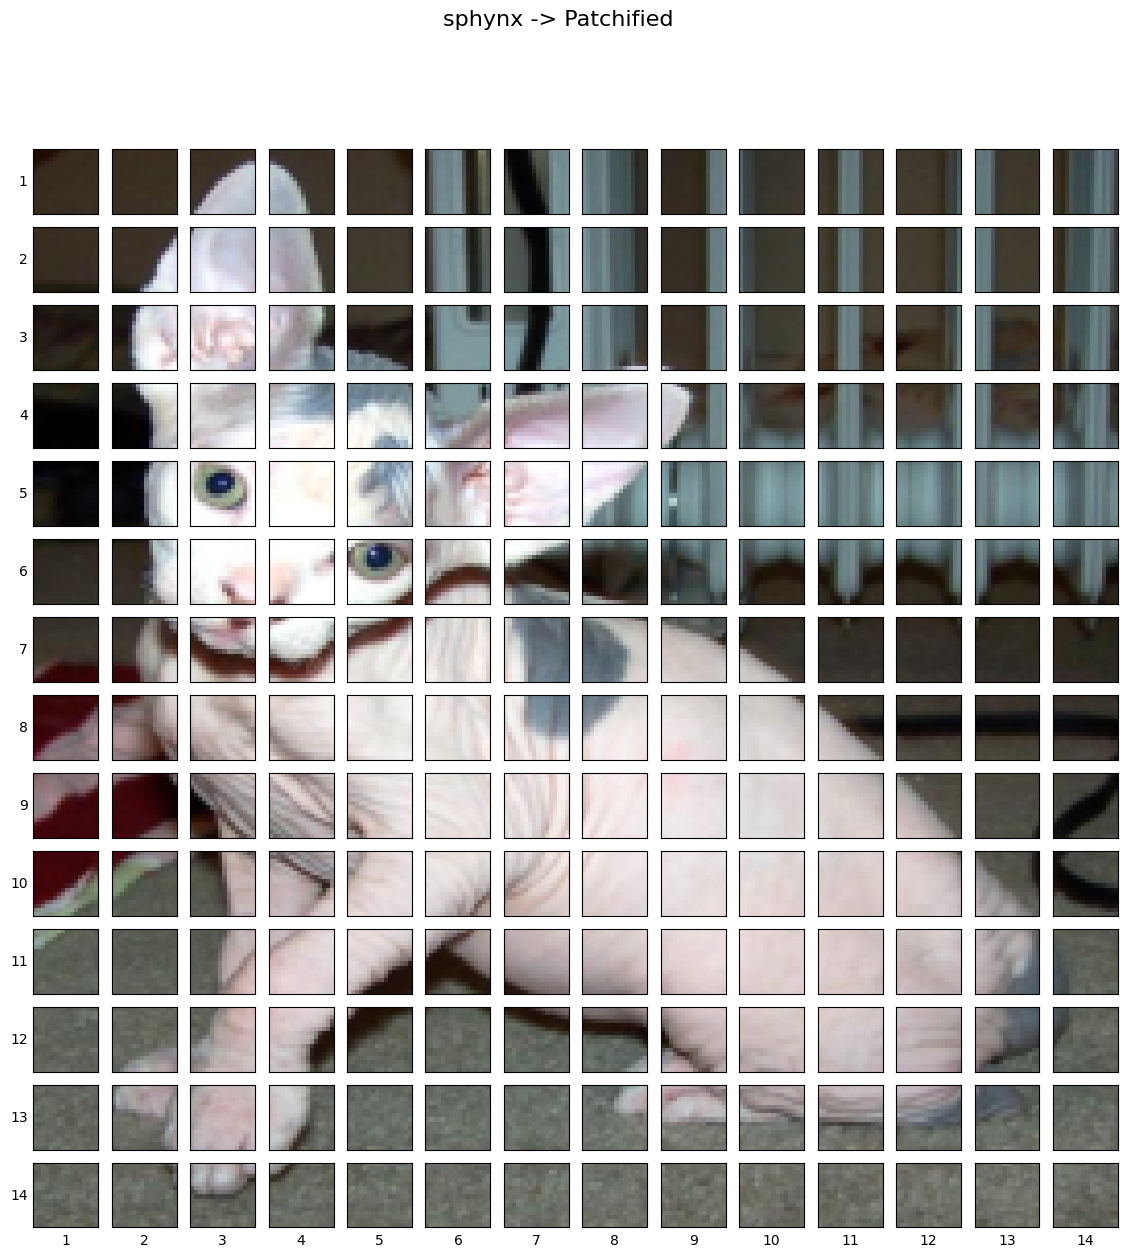

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

# 3.3 Creating image patches with torch.nn.Conv2d()

In [15]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

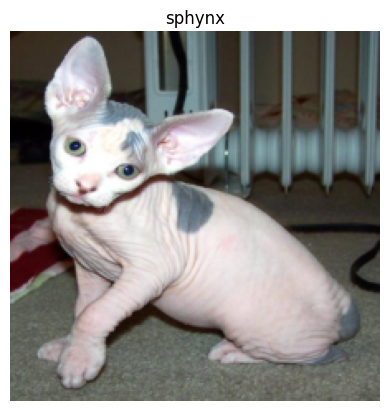

In [16]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [17]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Output shape: torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Showing random convolutional feature maps from indexes: [161, 502, 629, 431, 411]


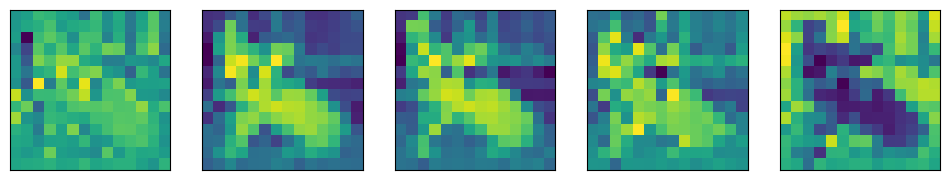

In [18]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [19]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 4.0211e-02,  3.5750e-02,  1.0171e-01,  4.3419e-02,  4.4708e-02,
            1.9695e-01,  4.7675e-02,  1.3018e-01,  5.6723e-02,  2.3574e-02,
            1.7250e-01,  5.8023e-02,  2.0971e-02,  1.8574e-01],
          [ 3.8630e-02, -8.6322e-02,  4.1907e-01,  2.7675e-01,  6.0013e-02,
            2.5386e-01,  2.9264e-02,  1.4734e-01,  6.0038e-02,  3.0763e-02,
            1.7928e-01,  6.0288e-02,  1.5219e-02,  2.2879e-01],
          [ 5.0784e-03,  4.8960e-01,  4.0485e-01,  2.1660e-01, -8.3314e-03,
            3.2824e-01,  8.5518e-03,  2.5892e-01,  8.1915e-02,  2.5442e-02,
            1.9572e-01,  2.1006e-02, -1.8526e-02,  2.5031e-01],
          [-6.6981e-03,  1.7117e-01,  3.1289e-01,  3.1808e-01,  4.3794e-01,
            3.0007e-01,  2.9141e-01,  3.7594e-01,  8.3097e-02,  2.0267e-02,
            2.3207e-01,  5.2485e-02,  2.8043e-02,  2.4006e-01],
          [-2.2652e-02,  2.4199e-01, -3.4132e-02,  4.6266e-01,  1.9494e-01,
            3.0625e-01,  5.0237e-01,  4.3518e-01,  2.2575e-0

## 3.4 Flattening the patch embedding with torch.nn.Flatten()

In [20]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [21]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


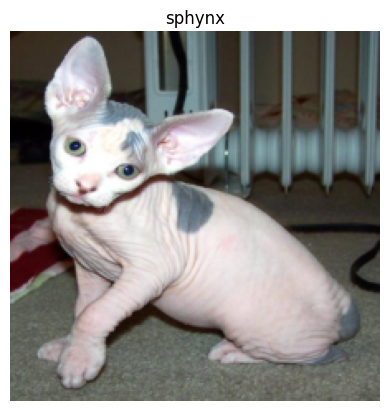

In [22]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [23]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


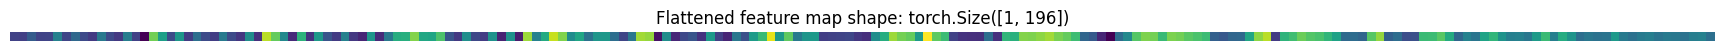

In [24]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [25]:
# See the flattened feature map as a tensor (turn 2D image into a 1D learnable embedding vector
# (or "Linear Projection of Flattened Patches" in Figure 1 of the ViT paper))
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 4.0211e-02,  3.5750e-02,  1.0171e-01,  4.3419e-02,  4.4708e-02,
           1.9695e-01,  4.7675e-02,  1.3018e-01,  5.6723e-02,  2.3574e-02,
           1.7250e-01,  5.8023e-02,  2.0971e-02,  1.8574e-01,  3.8630e-02,
          -8.6322e-02,  4.1907e-01,  2.7675e-01,  6.0013e-02,  2.5386e-01,
           2.9264e-02,  1.4734e-01,  6.0038e-02,  3.0763e-02,  1.7928e-01,
           6.0288e-02,  1.5219e-02,  2.2879e-01,  5.0784e-03,  4.8960e-01,
           4.0485e-01,  2.1660e-01, -8.3314e-03,  3.2824e-01,  8.5518e-03,
           2.5892e-01,  8.1915e-02,  2.5442e-02,  1.9572e-01,  2.1006e-02,
          -1.8526e-02,  2.5031e-01, -6.6981e-03,  1.7117e-01,  3.1289e-01,
           3.1808e-01,  4.3794e-01,  3.0007e-01,  2.9141e-01,  3.7594e-01,
           8.3097e-02,  2.0267e-02,  2.3207e-01,  5.2485e-02,  2.8043e-02,
           2.4006e-01, -2.2652e-02,  2.4199e-01, -3.4132e-02,  4.6266e-01,
           1.9494e-01,  3.0625e-01,  5.0237e-01,  4.3518e-01,  2.2575e-01,
           2.9470e-01,  1

## 3.5 Turning the ViT patch embedding layer into a PyTorch module

In [26]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [27]:
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [28]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # This will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
# summary(PatchEmbedding(),
#         input_size=random_input_image, # try swapping this for "random_input_image_error"
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

## 3.6 Creating the class token **embedding**

In [29]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0253,  0.1758, -0.0597,  ...,  0.1117,  0.0270, -0.0167],
         [-0.0515,  0.1752, -0.0851,  ...,  0.1063,  0.0025, -0.0185],
         [-0.1550,  0.6656, -0.4648,  ...,  0.3109,  0.1123,  0.0584],
         ...,
         [-0.2120,  0.4006, -0.2689,  ...,  0.2729,  0.0615, -0.0103],
         [-0.2389,  0.3774, -0.2917,  ...,  0.2611,  0.0475,  0.0053],
         [-0.2029,  0.3782, -0.2269,  ...,  0.2334,  0.0733, -0.0096]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [30]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [31]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0253,  0.1758, -0.0597,  ...,  0.1117,  0.0270, -0.0167],
         [-0.0515,  0.1752, -0.0851,  ...,  0.1063,  0.0025, -0.0185],
         ...,
         [-0.2120,  0.4006, -0.2689,  ...,  0.2729,  0.0615, -0.0103],
         [-0.2389,  0.3774, -0.2917,  ...,  0.2611,  0.0475,  0.0053],
         [-0.2029,  0.3782, -0.2269,  ...,  0.2334,  0.0733, -0.0096]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## 3.7 Creating the position embedding

In [32]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0253,  0.1758, -0.0597,  ...,  0.1117,  0.0270, -0.0167],
          [-0.0515,  0.1752, -0.0851,  ...,  0.1063,  0.0025, -0.0185],
          ...,
          [-0.2120,  0.4006, -0.2689,  ...,  0.2729,  0.0615, -0.0103],
          [-0.2389,  0.3774, -0.2917,  ...,  0.2611,  0.0475,  0.0053],
          [-0.2029,  0.3782, -0.2269,  ...,  0.2334,  0.0733, -0.0096]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [33]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [34]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9747, 1.1758, 0.9403,  ..., 1.1117, 1.0270, 0.9833],
         [0.9485, 1.1752, 0.9149,  ..., 1.1063, 1.0025, 0.9815],
         ...,
         [0.7880, 1.4006, 0.7311,  ..., 1.2729, 1.0615, 0.9897],
         [0.7611, 1.3774, 0.7083,  ..., 1.2611, 1.0475, 1.0053],
         [0.7971, 1.3782, 0.7731,  ..., 1.2334, 1.0733, 0.9904]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## 3.8 Putting it all together: from image to embedding

In [35]:
# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# 4. Equation 2: Multi-Head Attention (MSA)

Input data have been patchified and embedded

!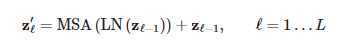

## 4.1 Replicating Equation 2 with PyTorch layers

In [36]:
## 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [37]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# 5. Equation 3: Multilayer Perceptron (MLP)


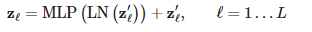

## 5.1 Replicating Equation 3 with PyTorch layers

In [38]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [39]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


# 6. Create the Transformer Encoder

x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...

## 6.1 Creating a Transformer Encoder by combining our custom made layers

In [40]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [41]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
# summary(model=transformer_encoder_block,
#         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

## 6.2 Creating a Transformer Encoder with PyTorch's Transformer layers

In [42]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [43]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# 7. Putting it all together to create ViT

In [44]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [45]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [46]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.1576,  1.0971,  0.2529]], grad_fn=<AddmmBackward0>)

## 7.1 Getting a visual summary of our ViT model

In [47]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

# 8. Setting up training code for our ViT model

## 8.1 Training our ViT model

In [48]:
from Part_3_pet_modules import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.3103 | train_acc: 0.3203 | test_loss: 2.8393 | test_acc: 0.3304
Epoch: 2 | train_loss: 1.7247 | train_acc: 0.3398 | test_loss: 1.6210 | test_acc: 0.3304
Epoch: 3 | train_loss: 1.2668 | train_acc: 0.2812 | test_loss: 1.1882 | test_acc: 0.3125
Epoch: 4 | train_loss: 1.1530 | train_acc: 0.3359 | test_loss: 1.1016 | test_acc: 0.3571
Epoch: 5 | train_loss: 1.1214 | train_acc: 0.2695 | test_loss: 1.1070 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.1204 | train_acc: 0.2656 | test_loss: 1.1232 | test_acc: 0.3304
Epoch: 7 | train_loss: 1.1102 | train_acc: 0.3359 | test_loss: 1.1295 | test_acc: 0.3571
Epoch: 8 | train_loss: 1.1273 | train_acc: 0.3438 | test_loss: 1.1629 | test_acc: 0.3304
Epoch: 9 | train_loss: 1.1463 | train_acc: 0.2969 | test_loss: 1.1202 | test_acc: 0.3125
Epoch: 10 | train_loss: 1.1155 | train_acc: 0.2891 | test_loss: 1.1038 | test_acc: 0.3304


## 8.2 What are missing in our training set-up

The original ViT architecture achieves good results on several image classification benchmarks (on par or better than many state-of-the-art results when it was released).

However, our results (so far) aren't as good.

There's a few reasons this could be but the main one is scale.

The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule (see Table 3).

| **Hyperparameter value** | **ViT Paper** | **Our implementation** |
| ----- | ----- | ----- |
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225 |
| Epochs | 7 (for largest dataset), 90, 300 (for ImageNet) | 10 |
| Batch size | 4096 | 32 |
| [Learning rate warmup](https://paperswithcode.com/method/linear-warmup) | 10k steps (Table 3) | None |
| [Learning rate decay](https://medium.com/analytics-vidhya/learning-rate-decay-and-methods-in-deep-learning-2cee564f910b#:~:text=Learning%20rate%20decay%20is%20a,help%20both%20optimization%20and%20generalization.) | Linear/Cosine (Table 3) | None |
| [Gradient clipping](https://paperswithcode.com/method/gradient-clipping) | Global norm 1 (Table 3) | None |

Even though our ViT architecture is the same as the paper, the results from the ViT paper were achieved using far more data and a more elaborate training scheme than ours.

Because of the size of the ViT architecture and its high number of parameters (increased learning capabilities), and amount of data it uses (increased learning opportunities), many of the techniques used in the ViT paper training scheme such as learning rate warmup, learning rate decay and gradient clipping are specifically designed to [prevent overfitting](https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting) (regularization).

## 8.3 Plot the loss curves of our ViT model

### 8.3.1 Download helper function

In [50]:
import requests
import os

# Step 1: Define the URL and local filename
url = "https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision/raw/refs/heads/master/helper_functions.py"
filename = "helper_functions.py"

# Step 2: Download the file if it doesn't exist
if not os.path.exists(filename):
    print(f"Downloading {filename} from {url}...")
    response = requests.get(url)
    response.raise_for_status()  # Ensure the download was successful
    with open(filename, "wb") as f:
        f.write(response.content)
    print(f"Downloaded {filename}.")
else:
    print(f"{filename} already exists, skipping download.")

Downloaded helper_functions.py.


### 8.3.2 Import the function and plot loss/accuracy curves

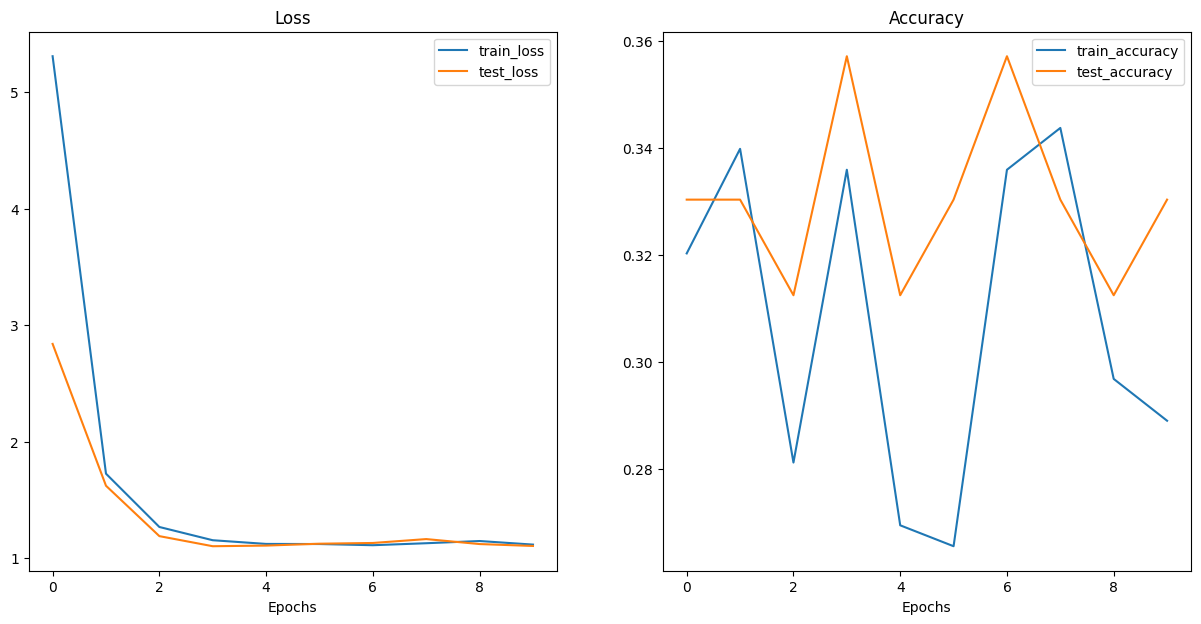

In [52]:
# Import the downloaded module and function
from helper_functions import plot_loss_curves

# Plot  ViT model's loss and accuaracy curves
plot_loss_curves(results)

# 9. Use a pretrained ViT from torchvision.models to improve our ViT model (transfer learning)

## 9.1 Getting a pretrained ViT model and creating a feature extractor

In [53]:
# Import libraries
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.4.1+cu121
0.19.1+cu121


'cuda'

In [54]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 48.2MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [55]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [56]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [57]:
# Set up directories
train_dir_50 = train_50_image_path / "data" / "images"
test_dir_50 = test_50_image_path / "data" / "images"

print(f"Training Directory (50%) for 3 classes: {train_dir_50}")
print(f"Testing Directory (50%) for 3 classes: {test_dir_50}")

Training Directory (50%) for 3 classes: data/train_data_50/data/images
Testing Directory (50%) for 3 classes: data/test_data_50/data/images


In [58]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir_50,
                                                                                                     test_dir=test_dir_50,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

## 9.2 Train feature extractor ViT model

In [59]:
from Part_3_pet_modules import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5935 | train_acc: 0.8438 | test_loss: 0.1788 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.1117 | train_acc: 1.0000 | test_loss: 0.0419 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0353 | train_acc: 1.0000 | test_loss: 0.0183 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0183 | train_acc: 1.0000 | test_loss: 0.0115 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0127 | train_acc: 1.0000 | test_loss: 0.0088 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0100 | train_acc: 1.0000 | test_loss: 0.0074 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0091 | train_acc: 1.0000 | test_loss: 0.0066 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0075 | train_acc: 1.0000 | test_loss: 0.0060 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0068 | train_acc: 1.0000 | test_loss: 0.0056 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0065 | train_acc: 1.0000 | test_loss: 0.0052 | test_acc: 1.0000


## 9.3 Plot feature extractor ViT model loss curves

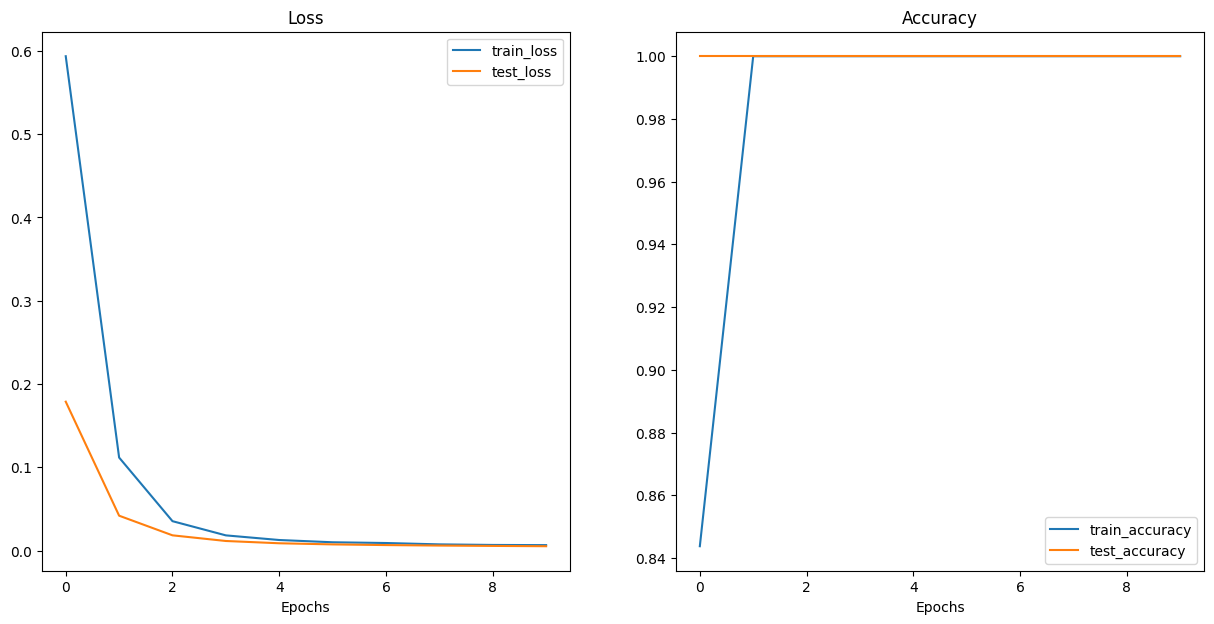

In [60]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## 9.5 Save feature extractor ViT model and check file size

In [61]:
# Save the model
from Part_3_pet_modules import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pytorch_pretrained_vit_feature_extractor_pet.pth")

[INFO] Model saved successfully at models/pytorch_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [64]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pytorch_pretrained_vit_feature_extractor_pet.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


# 10. Make predictions on a custom image

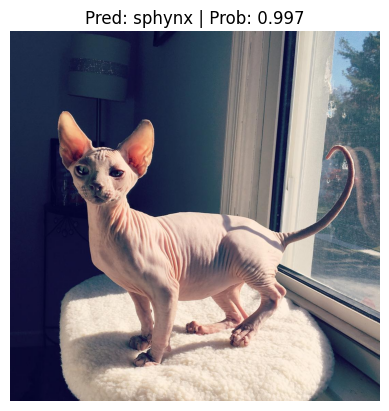

In [65]:
import requests
from pathlib import Path
from Part_3_pet_modules.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = Path("pet_custom_image.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    # request = requests.get("https://media-be.chewy.com/wp-content/uploads/2021/04/16140537/Boxer_Feature-Image-1024x615.jpg") # boxer
    # request = requests.get("https://www.pixelstalk.net/wp-content/uploads/2016/06/Free-HD-Pug-Wallpapers-Downlaod.jpg")   # pug
    request = requests.get("https://www.lifewithcatman.com/wp-content/uploads/2018/03/37004305_508868119547209_4582529976535875584_n.jpg") # sphynx
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit, image_path=custom_image_path, class_names=class_names)

In [66]:
# !rm -rf Part_3_pet_modules
# !rm -rf ./data